In this notebook, we will predict the likelihood of a heart attack using logistic regression model.

We will measure efficiency of the model by 4 metrics: accuracy, F1 score, precision and recall.

In [ ]:
#@title Install dependencies
!pip install dalex
!pip install lime
!pip install shap

In [ ]:
#@title Import modules

import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

import dalex as dx
import shap
import lime

# Data download

Please, write your Kaggle username and key below.

In [ ]:
import json 
import os
from pathlib import Path

# your api key
api_key = {
'username':"username" ,  # Edit this line.
'key':"key"}  # Edit this line.

# uses pathlib Path
kaggle_path = Path('/root/.kaggle')
os.makedirs(kaggle_path, exist_ok=True)

# opens file and dumps python dict to json object 
with open (kaggle_path/'kaggle.json', 'w') as handl:
    json.dump(api_key,handl)

os.chmod(kaggle_path/'kaggle.json', 600)  

In [ ]:
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()
filename = 'heart.csv'
api.dataset_download_file('rashikrahmanpritom/heart-attack-analysis-prediction-dataset', file_name=filename, path='./')

In [ ]:
df = pd.read_csv(filename).dropna()
df

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


# Data preparation

In [ ]:
df.describe().round(decimals=0)

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
count,303.0,303.0,303.0,303.0,303.0,303.0,303.0,303.0,303.0,303.0,303.0,303.0,303.0,303.0
mean,54.0,1.0,1.0,132.0,246.0,0.0,1.0,150.0,0.0,1.0,1.0,1.0,2.0,1.0
std,9.0,0.0,1.0,18.0,52.0,0.0,1.0,23.0,0.0,1.0,1.0,1.0,1.0,0.0
min,29.0,0.0,0.0,94.0,126.0,0.0,0.0,71.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,48.0,0.0,0.0,120.0,211.0,0.0,0.0,134.0,0.0,0.0,1.0,0.0,2.0,0.0
50%,55.0,1.0,1.0,130.0,240.0,0.0,1.0,153.0,0.0,1.0,1.0,0.0,2.0,1.0
75%,61.0,1.0,2.0,140.0,274.0,0.0,1.0,166.0,1.0,2.0,2.0,1.0,3.0,1.0
max,77.0,1.0,3.0,200.0,564.0,1.0,2.0,202.0,1.0,6.0,2.0,4.0,3.0,1.0


**Let us split the data into train and test.**

In [ ]:
X = df.iloc[:,:-1]
y = df['output']  
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
# Scale data with a standard scaler
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

# Load models

In [ ]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)

# Task 1
Calculate the predictions for some selected observations.

In [ ]:
X_train

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall
22,-1.367005,0.688495,-0.942428,0.507846,-0.436337,-0.412436,0.889908,1.205814,-0.619795,-0.883869,0.985218,-0.683642,-0.423094
247,1.253489,0.688495,0.043430,1.622212,-0.053984,-0.412436,0.889908,-1.411355,1.613436,-0.883869,-0.671408,2.155140,-2.050930
136,0.598365,-1.452442,1.029287,-0.606519,-1.353983,2.424621,0.889908,-2.494321,-0.619795,-0.883869,0.985218,-0.683642,-0.423094
102,0.925927,-1.452442,0.043430,0.507846,-1.028983,-0.412436,0.889908,1.250937,-0.619795,-0.883869,0.985218,1.208879,-0.423094
204,0.816740,-1.452442,-0.942428,1.622212,-1.621629,-0.412436,-1.015839,-0.283265,-0.619795,4.671990,-2.328033,2.155140,1.204742
...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,0.816740,0.688495,0.043430,-0.160773,-0.780454,2.424621,-1.015839,-0.508883,-0.619795,-0.883869,0.985218,-0.683642,-0.423094
89,0.379991,-1.452442,-0.942428,-1.720885,-0.015749,-0.412436,-1.015839,-1.321108,-0.619795,0.012238,-0.671408,-0.683642,-0.423094
132,-1.367005,0.688495,0.043430,-0.606519,0.882779,-0.412436,0.889908,0.483836,-0.619795,-0.883869,0.985218,-0.683642,-0.423094
282,0.489178,0.688495,1.029287,-0.272210,-0.589278,2.424621,0.889908,-0.779624,-0.619795,1.087565,-0.671408,0.262619,-2.050930


In [ ]:
random_numbers = np.random.choice(range(len(X_train)), 3, replace=False)
obs = X_train.iloc[random_numbers]
preds_lr = lr_model.predict(obs)
preds_knn = knn_model.predict(obs)

In [ ]:
obs

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall
177,1.035114,0.688495,1.029287,0.507846,1.647484,-0.412436,0.889908,0.303342,-0.619795,-0.883869,0.985218,-0.683642,-0.423094
90,-0.711882,0.688495,1.029287,-0.383646,0.118074,2.424621,0.889908,1.070443,-0.619795,-0.883869,0.985218,1.208879,-0.423094
43,-0.165945,-1.452442,-0.942428,-0.049336,0.290133,-0.412436,-1.015839,-0.373512,-0.619795,-0.525426,-0.671408,-0.683642,-0.423094


In [ ]:
print("Predictions:")
print(f"logistic regression: {preds_lr}")
print(f"KNN: {preds_knn}")

Predictions:
logistic regression: [1 1 1]
KNN: [1 1 1]


Note: 0 means disease and 1 means the opposite.

# Task 2
Calculate the decomposition of these predictions with LIME using the package of choice.

In [ ]:
explainer_lr = dx.Explainer(lr_model, X_train, y_train)
explainer_lr.model_performance(cutoff=y_train.mean())

Preparation of a new explainer is initiated

  -> data              : 227 rows 13 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 227 values
  -> model_class       : sklearn.linear_model._logistic.LogisticRegression (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x7f931d88e7a0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.00418, mean = 0.581, max = 0.997
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.964, mean = -2.74e-07, max = 0.93
  -> model_info        : package sklearn

A new explainer has been created!


X does not have valid feature names, but LogisticRegression was fitted with feature names


,recall,precision,f1,accuracy,auc
LogisticRegression,0.886364,0.879699,0.883019,0.863436,0.91874


In [ ]:
explainer_knn = dx.Explainer(knn_model, X_train, y_train)
explainer_knn.model_performance(cutoff=y_train.mean())

Preparation of a new explainer is initiated

  -> data              : 227 rows 13 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 227 values
  -> model_class       : sklearn.neighbors._classification.KNeighborsClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x7f931d88e7a0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 0.601, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.8, mean = -0.0194, max = 0.8
  -> model_info        : package sklearn

A new explainer has been created!


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


,recall,precision,f1,accuracy,auc
KNeighborsClassifier,0.916667,0.889706,0.902985,0.885463,0.949522


In [ ]:
predictions_lr = explainer_lr.predict(obs)
predictions_knn = explainer_knn.predict(obs)
predictions_lr, predictions_knn

(array([0.91764938, 0.87805283, 0.76345254]), array([0.8, 1. , 1. ]))

In [ ]:
explanation_lr1 = explainer_lr.predict_surrogate(obs.iloc[[0]])
explanation_lr2 = explainer_lr.predict_surrogate(obs.iloc[[1]])
explanation_lr3 = explainer_lr.predict_surrogate(obs.iloc[[2]])

explanation_knn1 = explainer_knn.predict_surrogate(obs.iloc[[0]])
explanation_knn2 = explainer_knn.predict_surrogate(obs.iloc[[1]])
explanation_knn3 = explainer_knn.predict_surrogate(obs.iloc[[2]])

# Task 3
Compare LIME for various observations in the dataset. How stable are these explanations?

## Logistic regression

                                 Observation 1                                  


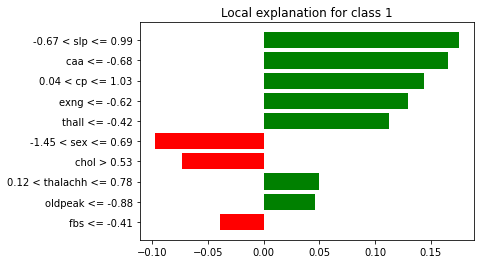

In [ ]:
columns = shutil.get_terminal_size().columns
print('\033[1m' + "Observation 1".center(columns))
explanation_lr1.plot()

                                 Observation 2                                  


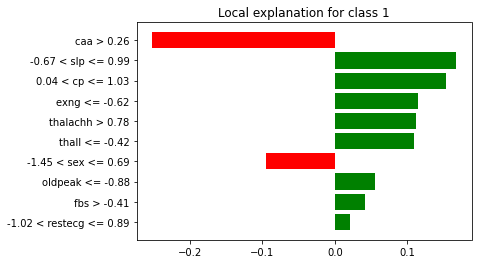

In [ ]:
print('\033[1m' + "Observation 2".center(columns))
explanation_lr2.plot()

                                 Observation 3                                  


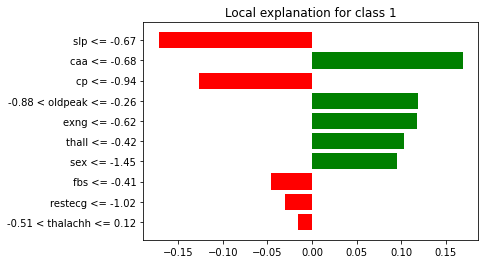

In [ ]:
print('\033[1m' + "Observation 3".center(columns))
explanation_lr3.plot()

The results for e.g. slp, cp or caa are completely different and even opposite for different observations, so the explanations are not very stable for logistic regression.

## KNN

                                 Observation 1                                  


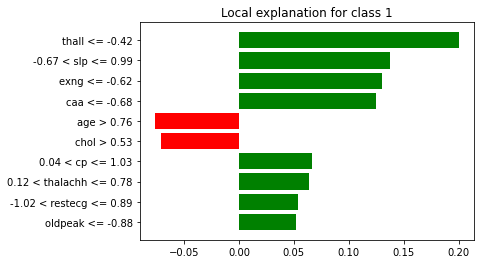

In [ ]:
print('\033[1m' + "Observation 1".center(columns))
explanation_knn1.plot()

                                 Observation 2                                  


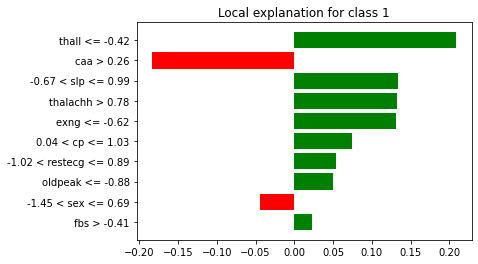

In [ ]:
print('\033[1m' + "Observation 2".center(columns))
explanation_knn2.plot()

                                 Observation 3                                  


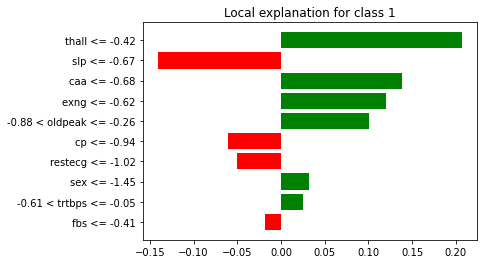

In [ ]:
print('\033[1m' + "Observation 3".center(columns))
explanation_knn3.plot()

Again these explanations are unstable.

# Task 5
Compare LIME between at least two different models. Are there any systematic differences across many observations?

According to the above plots, the explanations for the same observations and two different models are very similar, although the order of feature importance is slightly different.

# Task 4
Compare LIME with the explanations obtained using SHAP. What are the main differences between them?

In [ ]:
explainer = shap.Explainer(lr_model.predict, X_train)

In [ ]:
shap_values = explainer(obs)

                                 Observation 1                                  


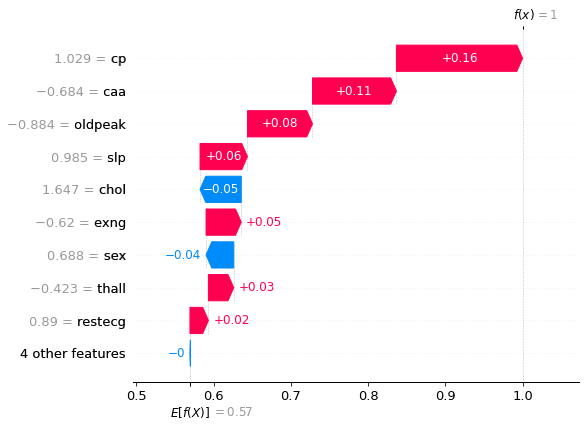

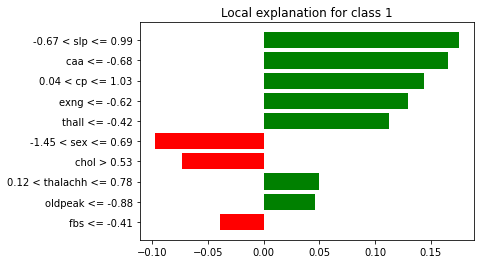

In [ ]:
print('\033[1m' + "Observation 1".center(columns))
shap.plots.waterfall(shap_values[0])
explanation_lr1.plot()

                                 Observation 2                                  


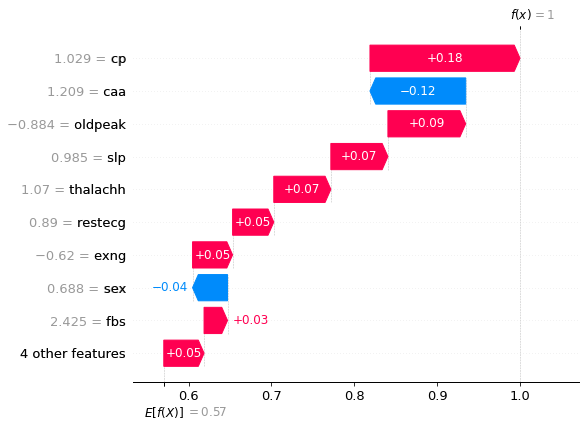

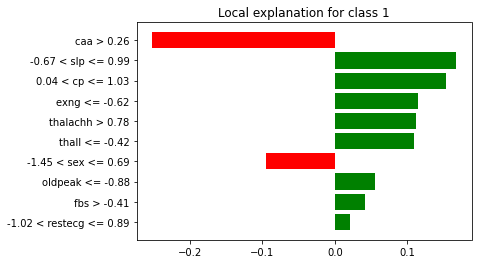

In [ ]:
print('\033[1m' + "Observation 2".center(columns))
shap.plots.waterfall(shap_values[1])
explanation_lr2.plot()

                                 Observation 3                                  


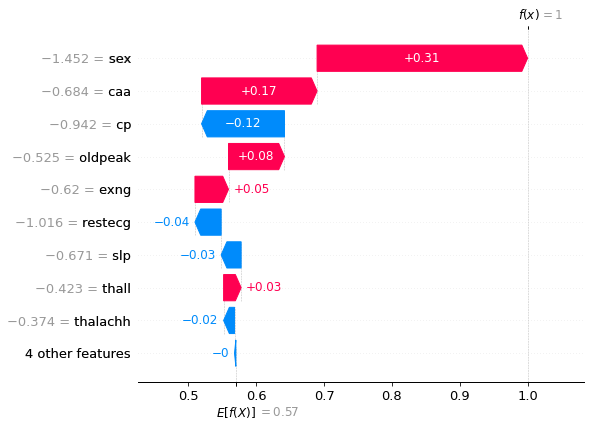

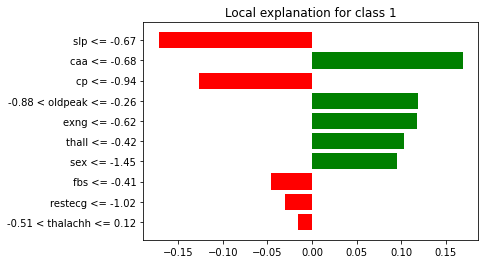

In [ ]:
print('\033[1m' + "Observation 3".center(columns))
shap.plots.waterfall(shap_values[2])
explanation_lr3.plot()

The explanations are similar. Signs are the same. There are some differences in order of feature importance. In some cases LIME has also bolder explanations.

# Task 6
Comment on the results obtained in (3), (4) and (5).

3. It is interesting that LIME explanations are not always stable. I will read more on that topic and how to deal with it. I can see that it may be caused by so called *Generation Step*.

4. Both of the methods are useful. I think that the choice depends on what we want to obtain. If we want to explain almost evry feature it is better to use SHAP, but if we want to have a simple, sparse and clear results, I would recommend LIME.

5. The results show that LIME method works both for KNN and Logistic regression in the same way, so (if it does for every other model) it is probably agnostic  - very good.